
# Maximal Representative Subsampling


In [1]:
from pathlib import Path
import os

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn import metrics
from scipy import stats

import pandas as pd
import pandas_profiling
#%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
np.seterr(divide = 'ignore')
import random

path = Path(os.getcwd()).parent

<div class="alert alert- block alert-warning"> <b>Todo:</b> --- </div>

### Plots

In [2]:
def plot_results(score, n, title):

    labels = [s[0] for s in score]
    preds = [s[1] for s in score]

    ks = [stats.ks_2samp(l, p) for l,p in zip(labels, preds)]
    auc = [metrics.roc_auc_score(l, p) for l,p in zip(labels, preds)]

    dropped = [n[0]-i for i in n]
    plots(dropped, [k[0] for k in ks], "KS")
    plots(dropped, [k[1] for k in ks], "KS (p-value)")
    plots(dropped, auc, "AUC")
    plt.legend(loc='lower left')
    plt.title(title)
    plt.savefig(title+'.png')
    plt.show()

def plots(x, y, name):
    plt.plot(x, y, label=name)
    if(name == "AUC"):
        plt.plot(x, len(x)*[0.5], linestyle='--')
    plt.xlabel("removed instances")
    plt.grid()

## MRS ALGORITHM

In [3]:
def temp_sample(softmax, temperature, drop):

    EPSILON = 10e-16 # to avoid taking the log of zero
    softmax = (np.array(softmax) + EPSILON).astype('float64')
    
    preds = np.log(softmax) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(drop, preds, 1)

    return probas[0]

def MRS(data, columns, temperature, n_drop = 20, limit = 50, 
        ensemble_size = 50, test_size = 0.3, baseline = False):
    
    data_base = data.copy(deep=True)
    
    global score
    global n
    global imp

    data = data_base.copy(deep=True)

    while (min(len(data[data.label == 1]), 
               len(data[data.label == 0])) > limit):    
        
        nonrep = data[data.label == 1].copy(deep=True)
        rep = data[data.label == 0].copy(deep=True)
        
        data = pd.concat([nonrep, rep], sort=True)

        train, test = train_test_split(data, test_size=test_size)
        test = pd.DataFrame(test)

        preds = [0]*len(test)
        for _ in range(ensemble_size):
            
            dt = DecisionTreeClassifier(max_depth=4)

            bootstrap = pd.DataFrame(train).sample(len(train), replace=True)
            dt.fit(bootstrap[columns], bootstrap.label)
            
            imp = [i + f for i,f in zip(imp, dt.feature_importances_)] ###
            
            prob = [p[1] for p in dt.predict_proba(test[columns])]
            preds = [pre + pro for pre,pro in zip(preds, prob)]
            
        preds = [f/ensemble_size for f in preds]
        
        score.append((test.label, preds))
        n.append(len(data.index))

        print(len(data.index), end=', ')

        if baseline == True: 
            preds = [random.random() for _ in preds]

        test['removed'] = temp_sample(preds, temperature, n_drop)
        test = test[test.removed == 0]
        test.drop('removed', axis=1, inplace=True) #inplace?

        data = pd.concat([train, test], sort=True)
    
    #return data

### US National Census (Income) <a name="us"></a>

*About this Dataset*

**US Adult Census** (1994) relates income to social factors: 

- *age*: continuous.
- *workclass*: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
- *fnlwgt*: continuous.
- *education*: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
- *education-num*: continuous.
- *marital-status*: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
- *occupation*: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
- *relationship*: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
- *race*: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
- *sex*: Female, Male.
- *capital-gain*: continuous.
- *capital-loss*: continuous.
- *hours-per-week*: continuous.
- *native-country*: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

Each row is labelled as either having a salary greater than ">50K" or "<=50K".

Note: This Dataset was obtained from the UCI repository, it can be found on

https://archive.ics.uci.edu/ml/datasets/census+income, http://mlr.cs.umass.edu/ml/machine-learning-databases/adult/

In [4]:
columns = ['Age','Workclass','fnlgwt','Education','Education Num','Marital Status',
           'Occupation','Relationship','Race','Sex','Capital Gain','Capital Loss',
           'Hours/Week','Country','Above/Below 50K']

train = pd.read_csv(os.path.join(path, 'data/census_income/adult.data'), names=columns)
test = pd.read_csv(os.path.join(path, 'data/census_income/adult.test'), names=columns)
test = test.iloc[1:]

df = pd.concat([train, test]).copy(deep=True)

del train, test

df.replace(' >50K.', ' >50K', inplace=True)
df.replace(' <=50K.', ' <=50K', inplace=True)

df.dropna(inplace=True)
df.reset_index(inplace=True, drop=True)

ctg = ['Workclass', 'Sex', 'Education', 'Marital Status', 
       'Occupation', 'Relationship', 'Race', 'Country']
for c in ctg:
    df = pd.concat([df, pd.get_dummies(df[c], 
                                       prefix=c,
                                       dummy_na=False)], axis=1).drop([c],axis=1)

'''Rep: <=50K    37155 ;; >50K     11687'''

df_high = df[df['Above/Below 50K'] == " >50K"].copy(deep=True)
df_low = df[df['Above/Below 50K'] == " <=50K"].copy(deep=True)

df_low = df_low.reindex(np.random.permutation(df_low.index))
df_high = df_high.reindex(np.random.permutation(df_high.index))

rep = pd.concat([df_low.head(15890).copy(deep=True),
                 df_high.head(5000).copy(deep=True)], sort=True)

nonrep = pd.concat([df_low.tail(15890).copy(deep=True),
                    df_high.tail(5000).copy(deep=True)], sort=True)

print('Rep: \n', rep['Above/Below 50K'].value_counts(), '\n')
print('Nonrep: \n', nonrep['Above/Below 50K'].value_counts())

nonrep['label'] = 1
rep['label'] = 0

del df, df_low, df_high

us = pd.concat([nonrep, rep], sort=True)

cols = list(us.columns)
meta = ['label', 'Above/Below 50K', 'index', 'bootstrap']
for m in meta:
    if m in cols:
        cols.remove(m)
        
us.head()

Rep: 
  <=50K    15890
 >50K      5000
Name: Above/Below 50K, dtype: int64 

Nonrep: 
  <=50K    15890
 >50K      5000
Name: Above/Below 50K, dtype: int64


,Above/Below 50K,Age,Capital Gain,Capital Loss,Country_ ?,Country_ Cambodia,Country_ Canada,Country_ China,Country_ Columbia,Country_ Cuba,...,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,Workclass_ Private,Workclass_ Self-emp-inc,Workclass_ Self-emp-not-inc,Workclass_ State-gov,Workclass_ Without-pay,fnlgwt,label
34653,<=50K,18,0.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,191817.0,1
35915,<=50K,38,0.0,0.0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,131288.0,1
12135,<=50K,40,0.0,0.0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,119493.0,1
38964,<=50K,46,0.0,0.0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,411595.0,1
24078,<=50K,28,0.0,0.0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,76313.0,1


In [5]:
allensbach = pd.read_csv(os.path.join(path, 'data/allensbach_mrs.csv'))

allensbach.drop(['Unnamed: 0'], axis=1, inplace=True)

columns = ['BRS1', 'BRS2', 'BRS3', 'BRS4', 'BRS5', 'BRS6', 'Berufsgruppe', 'Erwerbstätigkeit', 'Geschlecht',
          'Optimismus', 'Pessimismus', 'Schulabschluss', 'woechentlicheArbeitszeit']
#allensbach = allensbach[columns]

#profile = allensbach.profile_report(title='Allensbach Profiling Report')
#profile.to_file("Allensbach data profiling.html")
allensbach.head()

,Alter,BRS1,BRS2,BRS3,BRS4,BRS5,BRS6,Berufsgruppe,Erwerbstätigkeit,Geschlecht,IE_ext1,IE_ext2,IE_int1,IE_int2,Id,Optimismus,Pessimismus,Schulabschluss,label,woechentlicheArbeitszeit
0,48.0,3.0,2.0,3.0,3.0,3.0,4.0,4.0,1.0,1.0,4.0,4.0,3.0,3.0,GBS+00027,3.0,4.0,3.0,1,4.0
1,68.0,5.0,1.0,5.0,1.0,5.0,1.0,8.0,1.0,2.0,2.0,1.0,5.0,5.0,GBS+00032,7.0,1.0,5.0,1,1.0
2,56.0,4.0,4.0,2.0,4.0,2.0,4.0,4.0,1.0,2.0,3.0,3.0,3.0,3.0,GBS+00071,4.0,4.0,3.0,1,3.0
3,55.0,4.0,2.0,4.0,3.0,4.0,2.0,3.0,1.0,2.0,2.0,2.0,4.0,4.0,GBS+00084,5.0,2.0,4.0,1,3.0
4,60.0,5.0,2.0,5.0,2.0,5.0,2.0,3.0,1.0,2.0,2.0,2.0,4.0,4.0,GBS+00092,6.0,2.0,5.0,1,5.0


In [6]:
score = []
n = []
imp = [0]*len(columns)

MRS(data=allensbach, columns=columns, temperature=0.2, n_drop=10)

1632, 1622, 1613, 1604, 1594, 1584, 1575, 1565, 1556, 1546, 1537, 1529, 1519, 1510, 1502, 1494, 1485, 1476, 1467, 1459, 1449, 1440, 1431, 1423, 1413, 1405, 1398, 1390, 1382, 1374, 1365, 1356, 1346, 1337, 1327, 1320, 1310, 1301, 1291, 1283, 1273, 1265, 1255, 1246, 1236, 1230, 1220, 1212, 1203, 1194, 1185, 1175, 1165, 1157, 1150, 1142, 1134, 1125, 1115, 1109, 1101, 1091, 1086, 1083, 1075, 1071, 1061, 1052, 1043, 1035, 1025, 1019, 1014, 1008, 1000, 994, 987, 980, 971, 965, 957, 948, 941, 933, 924, 919, 911, 906, 899, 890, 882, 873, 

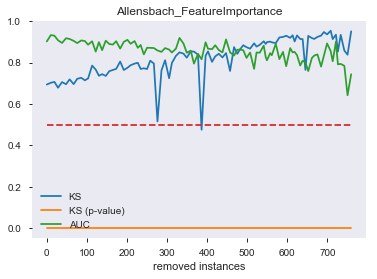

In [7]:
plot_results(score, n, 'Allensbach_FeatureImportance')

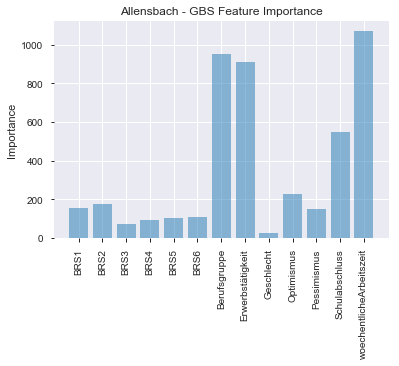

In [11]:
y_pos = np.arange(len(columns))

plt.bar(y_pos, imp, align='center', alpha=0.5)
plt.xticks(y_pos, columns, rotation=90)
plt.ylabel('Importance')
plt.title('Allensbach - GBS Feature Importance')
plt.show()